In [80]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

import numpy as np

import plotly.express as px

In [81]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
df = pd.read_csv('/Users/jmmill29/Desktop/heart.csv')

In [83]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [84]:
# Feature and label transformations

df_features = df.drop(['target'], axis = 1)
df_labels = df.loc[:, 'target']

# Get one-hot columns for nominal variables to pass to neural net classifier

new_cols = pd.concat([pd.get_dummies(df_features.loc[:, 'sex'], dtype = float, prefix='sex'),
            pd.get_dummies(df_features.loc[:, 'cp'], dtype = float, prefix='cp'),
            pd.get_dummies(df_features.loc[:, 'fbs'], dtype = float, prefix='fbs'),
            pd.get_dummies(df_features.loc[:, 'restecg'], dtype = float, prefix='restecg'),
            pd.get_dummies(df_features.loc[:, 'exang'], dtype = float, prefix='exang'),
            pd.get_dummies(df_features.loc[:, 'thal'], dtype = float, prefix = 'thal')], axis = 1)

df_features_dummies = pd.concat([df_features, new_cols], axis = 1).drop(['sex', 'cp', 'fbs',
                                                                            'restecg', 'exang', 'thal'], axis = 1)

In [85]:
df_features_dummies

,age,trestbps,chol,thalach,oldpeak,slope,ca,sex_0,sex_1,cp_0,...,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,thal_0,thal_1,thal_2,thal_3
0,52,125,212,168,1.0,2,2,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,53,140,203,155,3.1,0,0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,70,145,174,125,2.6,0,0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,61,148,203,161,0.0,2,1,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,62,138,294,106,1.9,1,3,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,140,221,164,0.0,2,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1021,60,125,258,141,2.8,1,1,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1022,47,110,275,118,1.0,1,1,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1023,50,110,254,159,0.0,2,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [86]:
# Check for balance in class representation

df_labels.value_counts()

target
1    526
0    499
Name: count, dtype: int64

In [87]:
# Standard neural net classifier. We will use the modern and numerically stable nn.BCEWithLogitsLoss which
# applies the sigmoid internally and therefore the final output of our net is a single neuron
# without sigmoid 

class Classifier(nn.Module):

    def __init__(self, input_dim):
        super(Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, input_dim *4),
            nn.ReLU(),
            nn.Linear(input_dim * 4, input_dim *8),
            nn.ReLU(),
            nn.Linear(input_dim*8, input_dim *4),
            nn.ReLU(),
            nn.Linear(input_dim *4 , input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim //2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, 1)

        )

    def forward(self, x):
        return self.classifier(x)

In [88]:
# A standard VAE class which we will use to test classification
# after latent encoding without simultaneous optimization of the latent encoding 

class VAE(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        
        # Input tensor size B x input_dim
        # Output tensor size B x latent_dim * 2
        # Output is mean and diagonal covariance matrix entries for Gaussian in latent space ( R^{latent_dim} )

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 16),
            nn.ReLU(),
            nn.Linear(latent_dim * 16 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 2),
        )


        # Input tensor size B x latent_dim
        # Output tensor size B x input_dim * 2
        # Output is mean and diagonal precision matrix (stability) entries for Gaussian in input space ( R^{input_dim} )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 16),
            nn.ReLU(),
            nn.Linear(input_dim * 16 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 2),
        )

        self.softplus = nn.Softplus()


      
    
    def encode(self, x, eps: float = 1e-8):

        # Get parameter vectors for latent Gaussian, ensure positive definite entries for covariance, embed entries in matrix
        # return distribution object, mean, log variance  

        z_params = self.encoder(x)
        mu, logvar = torch.chunk(z_params, 2, dim = -1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
    
    
        return [torch.distributions.MultivariateNormal(mu, scale_tril = scale_tril), mu, logvar]


      
    
    def reparam(self, dist):

        # Use built-in Pytorch reparameterization trick functionality to sample from distribution object  


        return dist.rsample()


    def decode(self, z):

        # Get mean and log precision for input space from latent representation

        x_params = self.decoder(z)
        mu, logprec = torch.chunk(x_params, 2, dim = -1)
        

        return [mu, logprec]


    def forward(self, x):

        # Get latent space parameter vectors, sample from latent space using these vectors, get reconstructed input parameter
        # vectors from latent space sample, return all vectors

        z_dist, z_mu, z_logvar = self.encode(x)
        z = self.reparam(z_dist)
        x_mu, x_logprec = self.decode(z)


        return [x_mu, x_logprec, z_mu, z_logvar] 



    def loss_function(self, x, params, prior_scale,
                                        recon_penalty,
                                        kld_penalty): 
                                        
                                        # prior_scale is float to constrain the Guassian prior over latent space
                                        # recon_penalty constrains the recon_loss
                                        # kld_penalty constrains the kld loss

        # Minimize the negative elbo (reconstruction score + KL Divergence between Gaussion prior and posterior
        # over latent sapce)

        x_mu, x_logprec, z_mu, z_logvar = params

        l = x - x_mu
        l2 = l**2

        recon_loss = torch.mean(0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1), dim = 0)
        scale = z_mu ** 2 + z_logvar.exp()
        scale = prior_scale * scale
        kld = torch.sum(1 + z_logvar - scale, dim = 1)
        kld =  - np.log(prior_scale) + kld
        kld = torch.mean(- 0.5 * kld, dim = 0)


        return recon_penalty * recon_loss +  kld_penalty * kld   

     
    def test_reconstruction_loss(self, x):

        # Get reconstruction scores for input tensor. Input is tensor of size N x input_dim where
        # N is the size of either train or test set. Output is tensor of size N. Average over 10
        # reconstruction samples to obtain stable estimate

       x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

       l = x - x_mu
       l2 = l**2

       recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)

       for i in range(0,9):
              x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

              l = x - x_mu
              l2 = l**2

              recon_loss_2 = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)
              recon_loss = recon_loss + recon_loss_2

       
       return recon_loss/10

    
    def reconstruct(x, model):

        # Reconstruct a given input tensor according to the generative model and return its associated
        # reconstruction score 
        
        z_dist, z_mu, z_logvar = model.encode(x)
        z = z_dist.sample()
        x_mu, x_logprec = model.decode(z)

        x_prec = torch.diag_embed(x_logprec.exp())
        x = torch.distributions.MultivariateNormal(x_mu, precision_matrix= x_prec).sample()

        l = x - x_mu
        l2 = l**2

        recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec, dim = 1)


        return [x, recon_loss]



In [89]:
# An encoder/classifier pair which first encodes features into latent space
# and then classifies based upon the expected value of the encoding. 
# We use a 10 sample Monte Carlo estimate for the expected value of the latent sample
# Encoder parameters here are optimized simultaneous to the classifier

class Latent_classifier(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(Latent_classifier, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 16),
            nn.ReLU(),
            nn.Linear(latent_dim * 16 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim *4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4, latent_dim *8),
            nn.ReLU(),
            nn.Linear(latent_dim*8, latent_dim *4),
            nn.ReLU(),
            nn.Linear(latent_dim *4 , latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim //2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, latent_dim // 4),
            nn.ReLU(),
            nn.Linear(latent_dim // 4, 1)
        )

        self.softplus = nn.Softplus()


    def encode(self, x, eps: float = 1e-8):

        # Get parameter vectors for latent Gaussian, ensure positive definite entries for covariance, embed entries in matrix
        # return distribution object, mean, log variance  

        z_params = self.encoder(x)
        mu, logvar = torch.chunk(z_params, 2, dim = -1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
    
    
        return [torch.distributions.MultivariateNormal(mu, scale_tril = scale_tril), mu, logvar]

    
    def reparam(self, dist):

        # Use built-in Pytorch reparameterization trick functionality to sample from distribution object  


        return dist.rsample()

    
    def forward(self, x):
        sample = self.reparam(self.encode(x)[0])
        for i in range(0,9):
            sample += self.reparam(self.encode(x)[0])
        latent = sample/10
    
        return self.classifier(latent)

In [90]:
def make_train_test_split(features, labels, split):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = split)
    mean = X_train.mean()
    std = np.sqrt(X_train.var())
    X_train = ( X_train - mean ) / std
    X_test = ( X_test - mean ) / std

    X_train_tensor = torch.Tensor(np.array(X_train))
    y_train_tensor = torch.Tensor(np.array(y_train)).reshape(-1,1) #BCEWithLogits requires 2d tensor for labels 
    X_test_tensor = torch.Tensor(np.array(X_test))
    y_test_tensor = torch.Tensor(np.array(y_test))

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor



In [91]:
# Define the training pipeline for the classifier
# This pipeline will be used on both the raw feature classifier
# as well as the latent space classifier

def classifier_train(model, optimizer, epochs, loss_fn, train_dl, fold):
    loss_hist_train = [0] * epochs 
    for epoch in range(epochs):
        for x,y in train_dl:
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits,y)
            loss.backward()
            optimizer.step() 
            loss_hist_train[epoch] += loss.item()
        print('Fold:', fold)
        print('Epoch:', epoch)
        print('Loss:', loss_hist_train[epoch])

    return loss_hist_train

In [92]:
# Standard VAE training pipeline to optimize ELBO

def vae_train(model, optimizer, train_dl, epochs, prior_scale, recon_penalty, kld_penalty, fold):
    loss_hist_train = [0] * epochs 
    for epoch in range(epochs):
        for data in train_dl:
            optimizer.zero_grad()
            params = model(data)
            loss = model.loss_function(data, params, prior_scale, recon_penalty, kld_penalty)
            loss.backward()
            optimizer.step() 
            loss_hist_train[epoch] += loss.item()
        print('Fold:', fold)
        print('Epoch:', epoch)
        print('Loss:', loss_hist_train[epoch])

    return loss_hist_train

In [93]:
# Return the accuracy of a given classifier on the test set

def test_accuracy(X_test_tensor, y_test_tensor, classifier):
    logits = classifier(X_test_tensor)
    sigmoid = nn.Sigmoid()
    probs = sigmoid(logits)
    probs = torch.flatten(probs)
    correct = (probs > .5).float() == y_test_tensor
    total = torch.sum(correct.float())
    accuracy = total/y_test_tensor.shape[0]
    return accuracy

Fold: 0
Epoch: 0
Loss: 13.962641030550003
Fold: 0
Epoch: 1
Loss: 8.872004747390747
Fold: 0
Epoch: 2
Loss: 6.69243212044239
Fold: 0
Epoch: 3
Loss: 5.890520043671131
Fold: 0
Epoch: 4
Loss: 4.615071896463633
Fold: 0
Epoch: 5
Loss: 4.169347755610943
Fold: 0
Epoch: 6
Loss: 2.913777773268521
Fold: 0
Epoch: 7
Loss: 3.196173097938299
Fold: 0
Epoch: 8
Loss: 2.033880232833326
Fold: 0
Epoch: 9
Loss: 5.103741388767958
Fold: 0
Epoch: 10
Loss: 2.2267062459141016
Fold: 0
Epoch: 11
Loss: 1.073753452161327
Fold: 0
Epoch: 12
Loss: 2.5575044313445687
Fold: 0
Epoch: 13
Loss: 1.2386064181337133
Fold: 0
Epoch: 14
Loss: 3.000702319899574
Fold: 0
Epoch: 15
Loss: 3.245045988820493
Fold: 0
Epoch: 16
Loss: 2.3142892359755933
Fold: 0
Epoch: 17
Loss: 1.2452632980421185
Fold: 0
Epoch: 18
Loss: 1.354245314898435
Fold: 0
Epoch: 19
Loss: 0.5976646271592472
Fold: 0
Epoch: 20
Loss: 0.2809863180737011
Fold: 0
Epoch: 21
Loss: 1.7765631416114047
Fold: 0
Epoch: 22
Loss: 0.8249314674176276
Fold: 0
Epoch: 23
Loss: 0.201993426

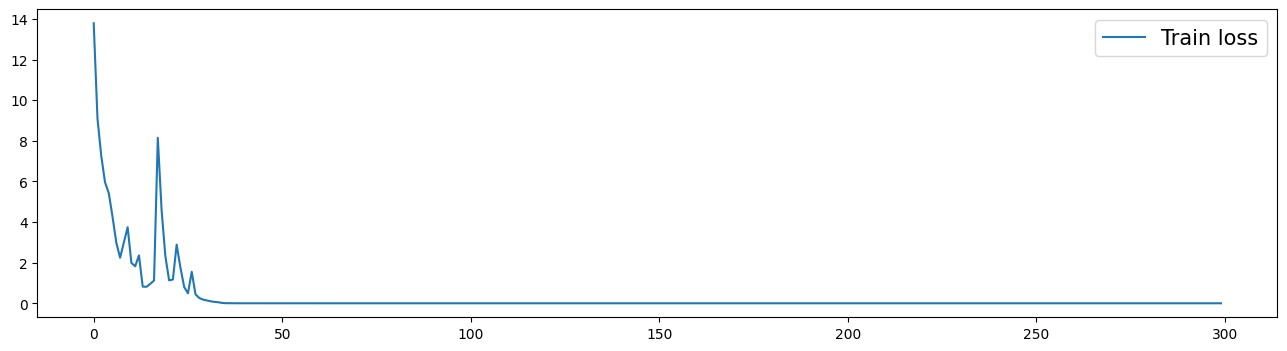

In [94]:
# Perform k-fold cross validation on the raw feature classifier

k_fold = 5
batch_size = 32
loss_fn = nn.BCEWithLogitsLoss()

accuracy = 0

for i in range(0,k_fold):

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = make_train_test_split(df_features_dummies, df_labels, 0.2)

# Initialize and train the raw feature classifier


    raw_classifier = Classifier( input_dim = X_train_tensor.shape[1] )
    raw_classifier_optimizer = torch.optim.Adam(raw_classifier.parameters(), lr=0.01)
    train_ds_raw_classifier = TensorDataset(X_train_tensor, y_train_tensor)
    train_dl_raw_classifier = DataLoader(train_ds_raw_classifier, batch_size, shuffle=True)

    history_raw_classifier = classifier_train(model = raw_classifier, 
                            optimizer = raw_classifier_optimizer, 
                            epochs=300, 
                            train_dl = train_dl_raw_classifier,
                            loss_fn = loss_fn,
                            fold = i)

    accuracy += test_accuracy(X_test_tensor, y_test_tensor, raw_classifier).item()
accuracy /= k_fold

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_raw_classifier)
plt.legend(['Train loss'], fontsize=15)
print('Accuracy:', accuracy)




In [97]:
# Train latent space classifier with ascending settings for dimension of latent space representation
# to test the dimension onto which we can project the features in latent space while maintaining high
# accuracy

batch_size_latent = 64
loss_fn = nn.BCEWithLogitsLoss()

# We use a slightly smaller k_fold for computation time but 
# can increase if a more accurate measurement is needed

k_fold = 3
accuracy_dims = [0] * 5

for i in range(2,7):
    for k in range(0,k_fold):

        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = make_train_test_split(df_features_dummies, df_labels, 0.2)

        latent_classifier = Latent_classifier(input_dim = X_train_tensor.shape[1], latent_dim = i * 5)
        latent_classifier_optimizer = torch.optim.Adam(latent_classifier.parameters(), lr=0.001)
        train_ds_latent_classifier = TensorDataset(X_train_tensor, y_train_tensor)
        train_dl_latent_classifier = DataLoader(train_ds_latent_classifier, batch_size_latent, shuffle=True)

        history_latent_classifier = classifier_train(model=latent_classifier, 
                            optimizer=latent_classifier_optimizer, 
                            epochs=200, 
                            train_dl = train_dl_latent_classifier,
                            loss_fn = loss_fn,
                            fold = k-2)

        accuracy_dims[i-2] += test_accuracy(X_test_tensor, y_test_tensor, latent_classifier).item()
    accuracy_dims[i-2] /= k_fold
    
print('Accuracy 10 dim:', accuracy_dims[0])
print('Accuracy 15 dim:', accuracy_dims[1])
print('Accuracy 20 dim:', accuracy_dims[2])
print('Accuracy 25 dim:', accuracy_dims[3])
print('Accuracy 30 dim:', accuracy_dims[4])



Fold: 0
Epoch: 0
Loss: 9.036295890808105
Fold: 0
Epoch: 1
Loss: 9.028848052024841
Fold: 0
Epoch: 2
Loss: 9.002434372901917
Fold: 0
Epoch: 3
Loss: 8.927817106246948
Fold: 0
Epoch: 4
Loss: 7.831886529922485
Fold: 0
Epoch: 5
Loss: 6.8939938843250275
Fold: 0
Epoch: 6
Loss: 6.475117713212967
Fold: 0
Epoch: 7
Loss: 6.16581317782402
Fold: 0
Epoch: 8
Loss: 5.961331397294998
Fold: 0
Epoch: 9
Loss: 5.826524376869202
Fold: 0
Epoch: 10
Loss: 5.76813280582428
Fold: 0
Epoch: 11
Loss: 5.655428320169449
Fold: 0
Epoch: 12
Loss: 5.558335244655609
Fold: 0
Epoch: 13
Loss: 5.514852225780487
Fold: 0
Epoch: 14
Loss: 5.399240881204605
Fold: 0
Epoch: 15
Loss: 5.285028368234634
Fold: 0
Epoch: 16
Loss: 5.142964214086533
Fold: 0
Epoch: 17
Loss: 5.045792460441589
Fold: 0
Epoch: 18
Loss: 4.940676182508469
Fold: 0
Epoch: 19
Loss: 4.835665762424469
Fold: 0
Epoch: 20
Loss: 4.735973536968231
Fold: 0
Epoch: 21
Loss: 4.693775564432144
Fold: 0
Epoch: 22
Loss: 4.647952973842621
Fold: 0
Epoch: 23
Loss: 4.628079444169998
Fol

Fold: 0
Epoch: 0
Loss: 315.2280921936035
Fold: 0
Epoch: 1
Loss: 314.7280683517456
Fold: 0
Epoch: 2
Loss: 312.52637100219727
Fold: 0
Epoch: 3
Loss: 313.53762912750244
Fold: 0
Epoch: 4
Loss: 312.45181369781494
Fold: 0
Epoch: 5
Loss: 312.88154125213623
Fold: 0
Epoch: 6
Loss: 312.4172010421753
Fold: 0
Epoch: 7
Loss: 312.6649522781372
Fold: 0
Epoch: 8
Loss: 311.9932174682617
Fold: 0
Epoch: 9
Loss: 311.126672744751
Fold: 0
Epoch: 10
Loss: 311.79495334625244
Fold: 0
Epoch: 11
Loss: 312.16874408721924
Fold: 0
Epoch: 12
Loss: 312.3218469619751
Fold: 0
Epoch: 13
Loss: 310.7201404571533
Fold: 0
Epoch: 14
Loss: 311.5446729660034
Fold: 0
Epoch: 15
Loss: 312.1851215362549
Fold: 0
Epoch: 16
Loss: 311.8691005706787
Fold: 0
Epoch: 17
Loss: 313.3611421585083
Fold: 0
Epoch: 18
Loss: 311.1741580963135
Fold: 0
Epoch: 19
Loss: 312.2074375152588
Fold: 0
Epoch: 20
Loss: 311.35863304138184
Fold: 0
Epoch: 21
Loss: 312.00834465026855
Fold: 0
Epoch: 22
Loss: 312.9469919204712
Fold: 0
Epoch: 23
Loss: 312.112449645

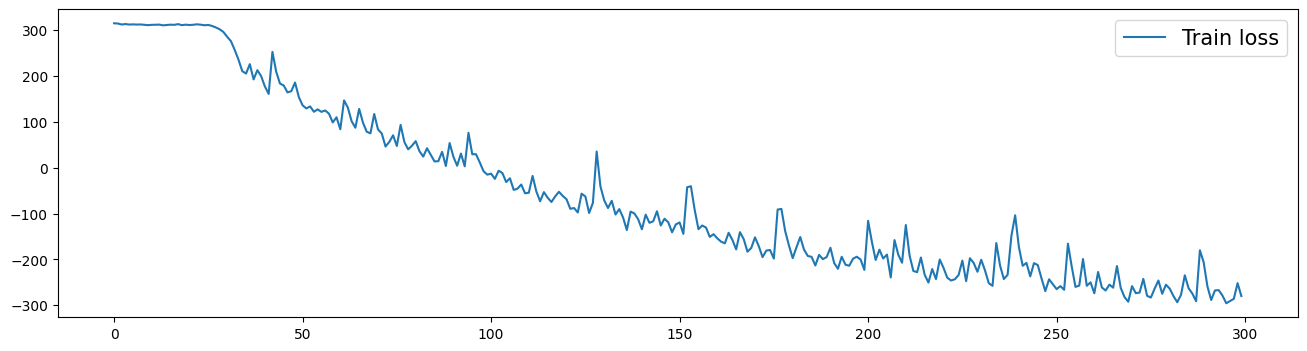

In [98]:
# Define and train the variational autoencoder
# We use the smallest dimension latent representation which achieved highest classification
# accuracy 

latent_model = VAE(input_dim = X_train_tensor.shape[1] , latent_dim = 20)
latent_model_optimizer = torch.optim.AdamW(latent_model.parameters(), lr = 1e-4)
train_dl_latent_model = DataLoader(X_train_tensor, batch_size, shuffle = True)

history_vae = vae_train(model=latent_model, 
                        optimizer=latent_model_optimizer, 
                        train_dl = train_dl_latent_model,
                        epochs=300, 
                        prior_scale=1,
                        recon_penalty=1,
                        kld_penalty=1,
                        fold = 0)

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_vae)
plt.legend(['Train loss'], fontsize=15)



Fold: 0
Epoch: 0
Loss: 8.978172957897186
Fold: 0
Epoch: 1
Loss: 8.840465724468231
Fold: 0
Epoch: 2
Loss: 8.283850193023682
Fold: 0
Epoch: 3
Loss: 7.157827645540237
Fold: 0
Epoch: 4
Loss: 6.676795095205307
Fold: 0
Epoch: 5
Loss: 6.491931676864624
Fold: 0
Epoch: 6
Loss: 6.237202733755112
Fold: 0
Epoch: 7
Loss: 5.985914409160614
Fold: 0
Epoch: 8
Loss: 5.724473655223846
Fold: 0
Epoch: 9
Loss: 5.50146672129631
Fold: 0
Epoch: 10
Loss: 5.251481860876083
Fold: 0
Epoch: 11
Loss: 5.011422425508499
Fold: 0
Epoch: 12
Loss: 4.586791902780533
Fold: 0
Epoch: 13
Loss: 4.366101086139679
Fold: 0
Epoch: 14
Loss: 4.361706301569939
Fold: 0
Epoch: 15
Loss: 3.8698004484176636
Fold: 0
Epoch: 16
Loss: 3.5880396217107773
Fold: 0
Epoch: 17
Loss: 3.2984719425439835
Fold: 0
Epoch: 18
Loss: 3.04481540620327
Fold: 0
Epoch: 19
Loss: 2.898265093564987
Fold: 0
Epoch: 20
Loss: 2.6883444264531136
Fold: 0
Epoch: 21
Loss: 2.5791133865714073
Fold: 0
Epoch: 22
Loss: 2.4679872393608093
Fold: 0
Epoch: 23
Loss: 2.37780174612998

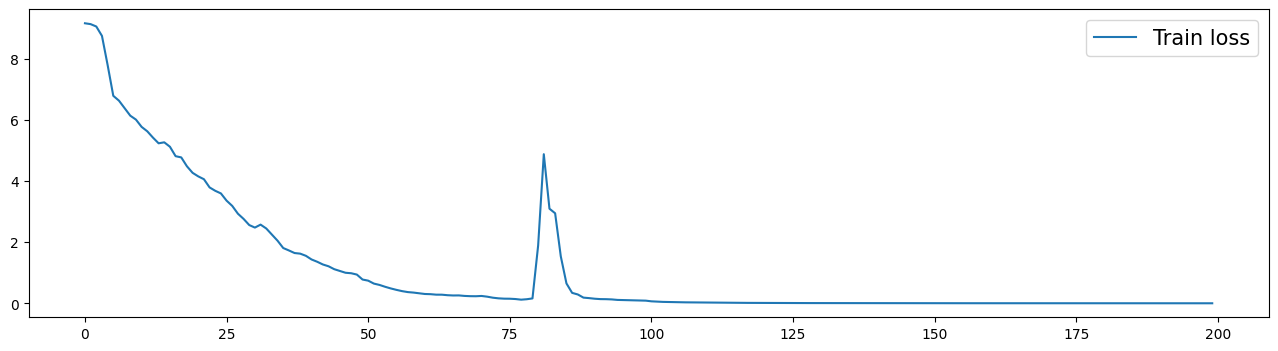

In [99]:
# Transform the features according to the latent space representation learned by the autoencoder without simultaneous
# optimization, retrain classifier on transformed features and test accuracy

batch_size = 64
k_fold = 5
accuracy = 0
for i in range (0,k_fold):

    latent_train = pd.DataFrame(latent_model.reparam(latent_model.encode(X_train_tensor)[0]).detach().numpy())
    latent_test = pd.DataFrame(latent_model.reparam(latent_model.encode(X_test_tensor)[0]).detach().numpy())

    mean = latent_train.mean()
    std = np.sqrt(latent_train.var())
    latent_train = ( latent_train - mean ) / std
    latent_test = ( latent_test - mean ) / std

    latent_train_tensor = torch.Tensor(np.array(latent_train))
    latent_test_tensor = torch.Tensor(np.array(latent_test))

    latent_classifier_indiv = Classifier(input_dim=latent_train_tensor.shape[1])
    optimizer_latent_classifier_indiv = torch.optim.Adam(latent_classifier_indiv.parameters(), lr=0.001)

    train_ds_latent_classifier_indiv = TensorDataset(latent_train_tensor, y_train_tensor)
    train_dl_latent_classifier_indiv = DataLoader(train_ds_latent_classifier_indiv, batch_size, shuffle=True)
    history_latent_classifier_indiv = classifier_train(model=latent_classifier_indiv, 
                            optimizer=optimizer_latent_classifier_indiv, 
                            epochs=200, 
                            train_dl = train_dl_latent_classifier_indiv,
                            loss_fn = loss_fn,
                            fold = i)
    accuracy += test_accuracy(latent_test_tensor, y_test_tensor, latent_classifier_indiv).item()
accuracy /= k_fold

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_latent_classifier_indiv)
plt.legend(['Train loss'], fontsize=15)

print('Accuracy w/o simultaneous optimization:', accuracy)